# T79 Exonic and Intergenic Probes Plot

antman environment

In [1]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import sys
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
from hcr import * 

Initializing transcriptomics package
Initializing plotting package
Initializing HCR package


In [2]:
# Load genome
genome_fasta_path = '../raw-data/OBir/genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [3]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 

In [4]:
object_name = "../raw-data/OBir/transcriptome/biroi_transcriptome"
tr = load_transcriptome_object(object_name)

In [5]:
t79_intergenics_path = "T79-B2-intergenics-regions-2024-10-26.xlsx"
t79_exonic_path = "T79-B1-regions-2024-10-26.xlsx"

In [7]:
exonic_regions = pd.read_excel(f"../raw-data/OBir/T79 Probes/{t79_exonic_path}") 
exonic_regions = exonic_regions["Region"].values

In [8]:
intergenic_regions = pd.read_excel(f"../raw-data/OBir/T79 Probes/{t79_intergenics_path}")
intergenic_regions = intergenic_regions["Region"].values

In [9]:
TA = 79 

# Get genes 
genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values

# Get gene objects from tr 
gene_objects = [tr.get_gene(gene) for gene in genes]

# Print the number of genes 
print("Number of genes: ", len(gene_objects))

Number of genes:  12


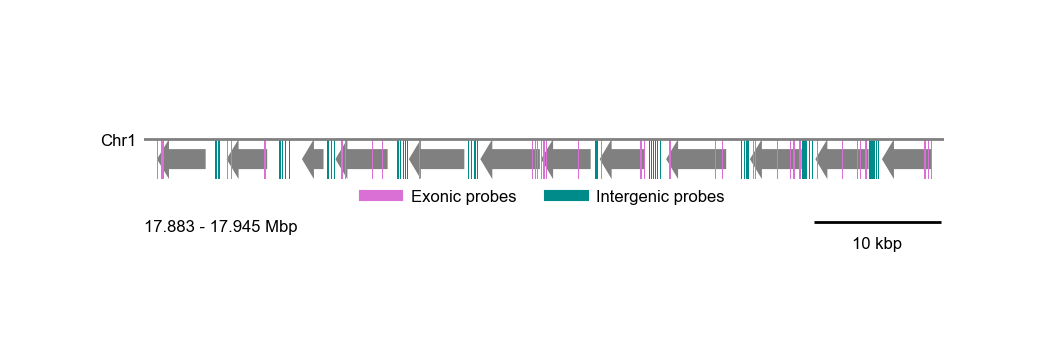

In [ ]:
# Create a new GenomeViz object
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=4, fig_track_height=0.4)

# Get bounds 
probe_length = 60 
chromosome = gene_objects[0].chromosome
bounds = [gene_object.get_transcript_longest_bounds().get_bounds() for gene_object in gene_objects]
min_start = int(np.min(bounds)) - 1000
max_end = int(np.max(bounds)) + 1000

track = gv.add_feature_track(chromosome, segments = (int(min_start), int(max_end)), labelsize=6)

# Labels 
gv.set_scale_bar(ymargin=0.5, labelsize=6, scale_size_label=(10_000, "10 kbp"))
track.add_sublabel(size=6, ymargin=1, text=f"{(min_start/1_000_000):.3f} - {(max_end/1_000_000):.3f} Mbp")

# Add gene models to plot 
for gene in gene_objects:
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = 1 if transcript.strand == '+' else -1
    track.add_feature(int(bounds[0]), 
                      int(bounds[1]), 
                      strand, 
                      plotstyle='arrow', 
                      fc="grey", 
                      alpha=1, 
                      arrow_shaft_ratio = 0.5, 
                      label=re.sub("Or5-", "", gene.name), 
                      ec="black", 
                      lw=0, 
                      text_kws={'color': 'black', 
                                'rotation': 0, 
                                'vpos': 'top', 
                                'hpos': 'center', 
                                'size':0
                                }
                        )


# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()
reverse_seq = reverse_complement(forward_seq)

## EXONIC 
# Annotate probe binding regions on forward strand 
for probe in exonic_regions:
    positions = [m.start() for m in re.finditer(probe, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + probe_length, 1, plotstyle="box", label = '', ec="none", fc="orchid", alpha=1)
    # Add reverse complement
    positions = [m.start() for m in re.finditer(probe, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - probe_length, max_end - position, -1, plotstyle="box", label = '', ec="none", fc="orchid", alpha=1)

## INTERGENIC 
# Annotate probe binding regions on forward strand 
for probe in intergenic_regions:
    positions = [m.start() for m in re.finditer(probe, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + probe_length, 1, plotstyle="box", label = '', ec="none", fc="darkcyan", alpha=1)
    # Add reverse complement
    positions = [m.start() for m in re.finditer(probe, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - probe_length, max_end - position, -1, plotstyle="box", label = '', ec="none", fc="darkcyan", alpha=1)

fig = gv.plotfig(dpi=200)

## Artificial legend 
plt.plot([], color='orchid', label='Exonic probes', lw=4)
plt.plot([], color='darkcyan', label='Intergenic probes', lw=4)
fig.legend(loc='lower center', fontsize=6, bbox_to_anchor=(0.5, -0.5), ncol=2, frameon=False)

ax = fig.gca()
#ax.set_title("Tandem Array 79", fontsize=6, color='black', y=1.4)


fig.savefig(f"../figures/t79-probes.pdf", pad_inches=0, dpi=200)

plt.show()

